In [1]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from lasagne.layers import InputLayer, DenseLayer, BatchNormLayer, Upscale2DLayer, NonlinearityLayer, ReshapeLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, dropout

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

second_dim = 1
img_size = 150

input_image_left  = T.tensor4('input_left')
input_image_positive = T.tensor4('input_positive')
input_image_negative = T.tensor4('input_negative')

l_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_left)
p_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_positive)
n_input = InputLayer(shape=(None, second_dim, img_size, img_size), input_var=input_image_negative)

conv1_filter_size = (3, 3)
conv1_num_filters = 20
conv2_filter_size = (5, 5)
conv2_num_filters = 15
conv2_stride = (1, 1)
pool1_size = (2, 2)
pool2_size = (4, 4)

my_nonlin = rectify
net = Conv2DLayer(l_input, conv1_num_filters, conv1_filter_size, nonlinearity=my_nonlin, W=lasagne.init.GlorotUniform())
net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, stride=conv2_stride, nonlinearity=my_nonlin)
net = MaxPool2DLayer(net, pool2_size)
net = DenseLayer(dropout(net, p=.5), num_units=256, nonlinearity=my_nonlin)
nn_l_out = DenseLayer(dropout(net, p=.5), num_units=128, nonlinearity=my_nonlin)

l_params = lasagne.layers.get_all_params(nn_l_out)

net = Conv2DLayer(p_input, conv1_num_filters, conv1_filter_size, nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])
net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, stride = conv2_stride, nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
net = MaxPool2DLayer(net, pool2_size)
net = DenseLayer(dropout(net, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_p_out = DenseLayer(dropout(net, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])
net = Conv2DLayer(n_input, conv1_num_filters, conv1_filter_size, 
                  nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])

net = MaxPool2DLayer(net, pool1_size)
net = Conv2DLayer(net, conv2_num_filters, conv2_filter_size, stride=conv2_stride, nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
net = MaxPool2DLayer(net, pool2_size)
net = DenseLayer(dropout(net, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_n_out = DenseLayer(dropout(net, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])

nn_merge = lasagne.layers.concat([nn_l_out, nn_p_out, nn_n_out], axis=1)
nn_out_test  = lasagne.layers.get_output(nn_merge, deterministic=True)

nn_out_left_test = nn_out_test[:, :128]
nn_out_positive_test = nn_out_test[:, 128:256]
nn_out_negative_test = nn_out_test[:, 256:]

d1_test = T.sum(T.sqr(nn_out_left_test - nn_out_positive_test), axis=1)
d2_test = T.sum(T.sqr(nn_out_left_test - nn_out_negative_test), axis=1)
test_fn = theano.function([input_image_left, input_image_positive, input_image_negative], [d1_test, d2_test], 
                          allow_input_downcast=True)

In [3]:
import cPickle as pickle
import os

import lasagne as nn

PARAM_EXTENSION = 'params'

def read_model_data(model, filename):
    """Unpickles and loads parameters into a Lasagne model."""
    filename = os.path.join('./', '%s.%s' % (filename, PARAM_EXTENSION))
    with open(filename, 'r') as f:
        data = pickle.load(f)
    nn.layers.set_all_param_values(model, data)

read_model_data(nn_merge, 'model')

In [5]:
files = np.load('data_set.npz')
X_train, y_train, X_val, y_val = files['X_train'], files['y_train'], files['X_test'], files['y_test']
for i in range(20):
    print(test_fn([X_val[i]], [X_val[i]], [X_val[9]])[1][0], y_val[i])

(23.975082, 5140)
(22.332117, 5141)
(227.20349, 5141)
(18.049051, 5142)
(22.860266, 5142)
(38.095673, 5143)
(361.05508, 5144)
(24.701733, 5145)
(43.491211, 5146)
(0.0, 5147)
(13.88477, 5147)
(11.28087, 5147)
(12.588659, 5147)
(10.444126, 5147)
(9.1962862, 5148)
(7.6889095, 5149)
(56.069298, 5150)
(38.167122, 5151)
(60.490044, 5151)
(17.410011, 5152)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

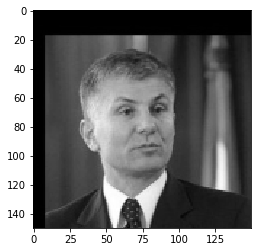

In [22]:
plt.imshow(X_train[5147][0], cmap='gray')

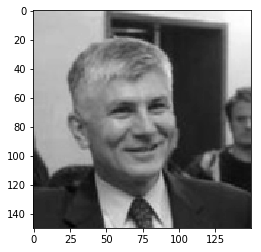

In [18]:
plt.imshow(X_train[5148][0], cmap='gray')

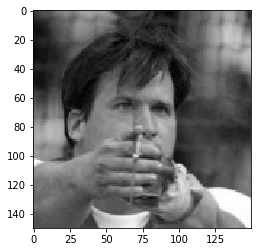

In [19]:
plt.imshow(X_train[5149][0], cmap='gray')

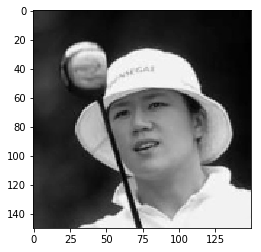

In [20]:
plt.imshow(X_train[5141][0], cmap='gray')